In [2]:
# =========================
# 0) Imports + Dataset path
# =========================
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

DATASET_DIR = Path(r"C:\Users\Admin\.cache\kagglehub\datasets\olafkrastovski\handwritten-digits-0-9\versions\2")

# Preprocess to "MNIST-like" (common for this dataset): grayscale -> resize -> invert -> normalize 
IMG_SIZE = (28, 28)
INVERT = True         # invert colors to match MNIST style (white digit on dark background)
NORMALIZE = True      # scale pixels to [0,1]

In [3]:
# ==========================================
# 1) Find the folder that contains 0..9 dirs
#    (handles nested structures automatically)
# ==========================================
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

def _count_images_in_dir(d: Path) -> int:
    return sum(1 for p in d.rglob("*") if p.is_file() and p.suffix.lower() in IMG_EXTS)

def find_digit_root(ds_dir: Path) -> Path:
    """
    Finds a directory that contains subfolders named 0..9.
    Chooses the candidate with the most images.
    """
    digit_names = {str(i) for i in range(10)}

    # find all directories named 0..9 anywhere under ds_dir
    digit_dirs = [p for p in ds_dir.rglob("*") if p.is_dir() and p.name in digit_names]
    if not digit_dirs:
        raise FileNotFoundError(
            f"Could not find any digit folders named 0..9 under: {ds_dir}"
        )

    # group by parent; candidate parent must contain all 10 digit folders
    parent_to_digits = {}
    for d in digit_dirs:
        parent_to_digits.setdefault(d.parent, set()).add(d.name)

    candidates = [parent for parent, names in parent_to_digits.items() if names == digit_names]
    if not candidates:
        # fallback: pick the parent with the most distinct digit folders (closest match)
        candidates = sorted(parent_to_digits.keys(), key=lambda p: len(parent_to_digits[p]), reverse=True)[:5]

    # choose candidate with max number of images
    best_parent = None
    best_count = -1
    for parent in candidates:
        n = sum(_count_images_in_dir(parent / str(i)) for i in range(10) if (parent / str(i)).is_dir())
        if n > best_count:
            best_count = n
            best_parent = parent

    if best_parent is None:
        raise FileNotFoundError("Could not determine a valid digit root containing folders 0..9.")

    print(f"[OK] Using digit root: {best_parent}  (images found ≈ {best_count})")
    return best_parent

In [4]:
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.feature import hog
from scipy.ndimage import center_of_mass, shift
import numpy as np
import os

IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp")

def preprocess_digit(img):
    # Grayscale
    if img.ndim == 3:
        if img.shape[2] == 4:
            img = rgba2rgb(img)
        img = rgb2gray(img)

    # Normalize 0-1
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # Threshold (Otsu)
    thresh = threshold_otsu(img)
    img = (img > thresh).astype(np.float32)

    # Ensure digit is white (foreground=1)
    # If background became 1 (common when digit is dark), invert.
    if img.mean() > 0.5:
        img = 1 - img

    # Bounding box crop
    coords = np.column_stack(np.where(img > 0))
    if coords.shape[0] == 0:
        return np.zeros((28, 28), dtype=np.float32)

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    digit = img[y_min:y_max+1, x_min:x_max+1]

    # Resize digit to 20x20
    digit = resize(digit, (20, 20), anti_aliasing=True).astype(np.float32)

    # Pad to 28x28
    canvas = np.zeros((28, 28), dtype=np.float32)
    canvas[4:24, 4:24] = digit

    # Center shift (center of mass)
    cy, cx = center_of_mass(canvas)
    shift_y = 14 - cy
    shift_x = 14 - cx

    # order=1 is a good compromise; mode constant keeps background black
    canvas = shift(canvas, (shift_y, shift_x), order=1, mode="constant", cval=0.0)

    return canvas




In [5]:
from skimage.io import imread

IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp")

def load_processed_images(base_path):
    imgs = []
    y = []

    for label in range(10):
        class_dir = os.path.join(base_path, str(label))
        for file in os.listdir(class_dir):
            if not file.lower().endswith(IMG_EXTS):
                continue
            img_path = os.path.join(class_dir, file)
            img = imread(img_path)
            img = preprocess_digit(img)     # (28,28) float
            imgs.append(img)
            y.append(label)

    imgs = np.array(imgs, dtype=np.float32)  # (N,28,28)
    y = np.array(y, dtype=np.int64)
    return imgs, y

imgs, y = load_processed_images(DATASET_DIR)
# Flatten images for PCA / stats    
X = imgs.reshape(len(imgs), -1)   # (N, 784)

print("X:", X.shape, "range:", (X.min(), X.max()))
print("imgs:", imgs.shape, "y:", y.shape)

X: (21555, 784) range: (0.0, 1.0)
imgs: (21555, 28, 28) y: (21555,)


In [6]:
# ==========================
# 3) Train/test split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Class distribution (train + valid):
0: count= 2536  freq=0.1033
1: count= 2541  freq=0.1035
2: count= 2533  freq=0.1032
3: count= 2502  freq=0.1019
4: count= 2479  freq=0.1010
5: count= 2426  freq=0.0988
6: count= 2421  freq=0.0986
7: count= 2416  freq=0.0984
8: count= 2385  freq=0.0971
9: count= 2316  freq=0.0943


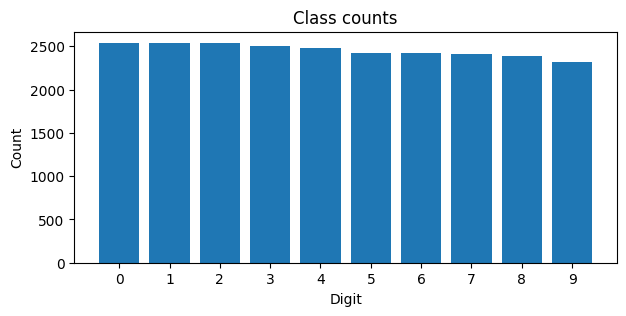

In [7]:
# ==========================
# 4) STATISTICS
# ==========================

# (A) Class distribution
counts = np.bincount(y, minlength=10) + 300
freq = counts / counts.sum()
print("\nClass distribution (train + valid):")
for d in range(10):
    print(f"{d}: count={counts[d]:5d}  freq={freq[d]:.4f}")

plt.figure(figsize=(7, 3))
plt.bar(range(10), counts)
plt.xticks(range(10))
plt.title("Class counts")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.savefig("class_counts.png",dpi=300, bbox_inches="tight")  # nice for LaTeX reports
plt.show() 

In [8]:
# (B) Overall pixel intensity stats
print("\nPixel stats:")
print("min/max:", float(X.min()), float(X.max()))
print("mean/std:", float(X.mean()), float(X.std()))


Pixel stats:
min/max: 0.0 1.0
mean/std: 0.08257163316011429 0.20887094736099243


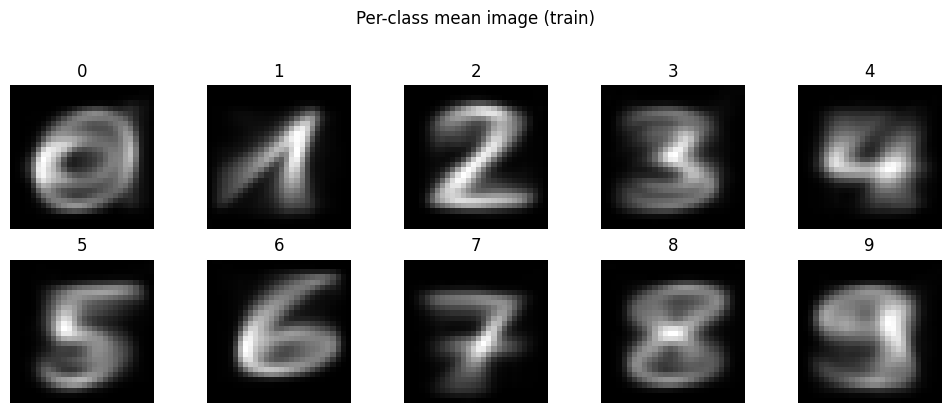

In [9]:
# (C) Per-class mean images (visual sanity check)
means = []
for d in range(10):
    class_mean = X_train[y_train == d].mean(axis=0).reshape(IMG_SIZE[1], IMG_SIZE[0])
    means.append(class_mean)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for d, ax in enumerate(axes.ravel()):
    ax.imshow(means[d], cmap="gray")
    ax.set_title(str(d))
    ax.axis("off")
plt.suptitle("Per-class mean image (train)", y=1.02)
plt.tight_layout()
plt.show()

In [10]:
# (D) Per-feature (pixel) mean/variance
pixel_mean = X_train.mean(axis=0)   # (784,)
pixel_var  = X_train.var(axis=0)    # (784,)
print("\nPer-pixel mean/var (averaged across pixels):")
print("mean(pixel_mean) =", float(pixel_mean.mean()))
print("mean(pixel_var)  =", float(pixel_var.mean()))



Per-pixel mean/var (averaged across pixels):
mean(pixel_mean) = 0.08269458264112473
mean(pixel_var)  = 0.03640018031001091



Components needed for target explained variance:
0.90: k = 216
0.95: k = 299
0.99: k = 480


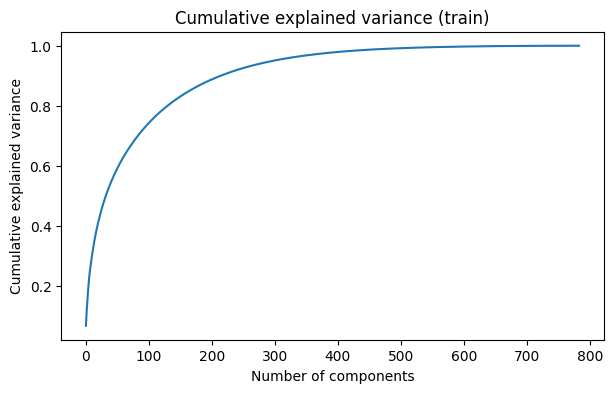

In [11]:
# ==========================
# 5) PCA 
# ==========================

# (A) Decide how many components needed for 90/95/99% variance
pca_full = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(random_state=0))
])
pca_full.fit(X_train)

evr = pca_full.named_steps["pca"].explained_variance_ratio_
cum = np.cumsum(evr)

print("\nComponents needed for target explained variance:")
for target in [0.90, 0.95, 0.99]:
    k = int(np.searchsorted(cum, target) + 1)
    print(f"{target:.2f}: k = {k}")

plt.figure(figsize=(7, 4))
plt.plot(cum)
plt.title("Cumulative explained variance (train)")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.savefig("pca_cumulative_variance.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
# (B) PCA pipeline that keeps 95% variance (auto-select k)
# Note: sklearn supports n_components as a float in (0,1) meaning "keep this variance"
pca95 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(n_components=0.95, random_state=0))
])
Z_train_95 = pca95.fit_transform(X_train)
print("\nPCA(95%) output shape:", Z_train_95.shape)
print("Chosen components:", pca95.named_steps["pca"].n_components_)



PCA(95%) output shape: (17244, 299)
Chosen components: 299


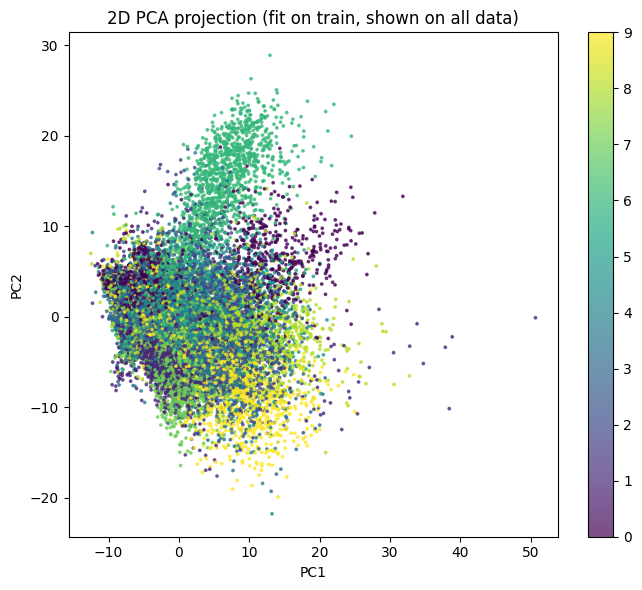

In [13]:
# (C) 2D PCA visualization, projected from 784D
# Heavy overlap between colors (0–9) means: PC1/PC2 are not enough to separate digits. That’s normal—PCA preserves variance, not class separation.
pca2 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(n_components=2, random_state=0))
])

Z2_train = pca2.fit_transform(X_train)   # fit only on training
Z2_test  = pca2.transform(X_test)        # transform test with same mapping

Z2_all = np.vstack([Z2_train, Z2_test])
y_all  = np.hstack([y_train, y_test])

plt.figure(figsize=(7, 6))
sc = plt.scatter(Z2_all[:, 0], Z2_all[:, 1], c=y_all, s=3, alpha=0.7)
plt.colorbar(sc, ticks=range(10))
plt.title("2D PCA projection (fit on train, shown on all data)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("pca_2d_all_fit_on_train.png", dpi=300, bbox_inches="tight")
plt.show()